In [1]:
# EDA pkgs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', color_codes=True)

In [2]:
eeg_data = pd.read_csv("EEG_data.csv")
demographic_data = pd.read_csv("demographic_info.csv")

In [3]:
eeg_data

,SubjectID,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel,user-definedlabeln
0,0.0,0.0,56.0,43.0,278.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0.0,0.0
1,0.0,0.0,40.0,35.0,-50.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0.0,0.0
2,0.0,0.0,47.0,48.0,101.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,0.0,0.0
3,0.0,0.0,47.0,57.0,-5.0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0,0.0,0.0
4,0.0,0.0,44.0,53.0,-8.0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12806,9.0,9.0,64.0,38.0,-39.0,127574.0,9951.0,709.0,21732.0,3872.0,39728.0,2598.0,960.0,1.0,0.0
12807,9.0,9.0,61.0,35.0,-275.0,323061.0,797464.0,153171.0,145805.0,39829.0,571280.0,36574.0,10010.0,1.0,0.0
12808,9.0,9.0,60.0,29.0,-426.0,680989.0,154296.0,40068.0,39122.0,10966.0,26975.0,20427.0,2024.0,1.0,0.0
12809,9.0,9.0,60.0,29.0,-84.0,366269.0,27346.0,11444.0,9932.0,1939.0,3283.0,12323.0,1764.0,1.0,0.0


In [4]:
demographic_data

,subject ID,age,ethnicity,gender
0,0,25,Han Chinese,M
1,1,24,Han Chinese,M
2,2,31,English,M
3,3,28,Han Chinese,F
4,4,24,Bengali,M
5,5,24,Han Chinese,M
6,6,24,Han Chinese,M
7,7,25,Han Chinese,M
8,8,25,Han Chinese,M
9,9,24,Han Chinese,F


### Data

These data are collected from ten students, each watching ten videos. Therefore, it can be seen as only 100 data points for these 12000+ rows. If you look at this way, then each data point consists of 120+ rows, which is sampled every 0.5 seconds (so each data point is a one minute video). Signals with higher frequency are reported as the mean value during each 0.5 second.

- EEG_data.csv: Contains the EEG data recorded from 10 students

- demographic.csv: Contains demographic information for each student

## Narrative:
We will merge the dataframe with respect to Subject ID.

- Unique identifer needs to be removed from the feature as in future this model can be generalize for any video.


## Merging DataFrame

In [5]:
demographic_data.rename(columns={"subject ID": "SubjectID"}, inplace = True)

In [6]:
data = demographic_data.merge(eeg_data, on='SubjectID')

In [7]:
data

,SubjectID,age,ethnicity,gender,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel,user-definedlabeln
0,0,25,Han Chinese,M,0.0,56.0,43.0,278.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0.0,0.0
1,0,25,Han Chinese,M,0.0,40.0,35.0,-50.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0.0,0.0
2,0,25,Han Chinese,M,0.0,47.0,48.0,101.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,0.0,0.0
3,0,25,Han Chinese,M,0.0,47.0,57.0,-5.0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0,0.0,0.0
4,0,25,Han Chinese,M,0.0,44.0,53.0,-8.0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12806,9,24,Han Chinese,F,9.0,64.0,38.0,-39.0,127574.0,9951.0,709.0,21732.0,3872.0,39728.0,2598.0,960.0,1.0,0.0
12807,9,24,Han Chinese,F,9.0,61.0,35.0,-275.0,323061.0,797464.0,153171.0,145805.0,39829.0,571280.0,36574.0,10010.0,1.0,0.0
12808,9,24,Han Chinese,F,9.0,60.0,29.0,-426.0,680989.0,154296.0,40068.0,39122.0,10966.0,26975.0,20427.0,2024.0,1.0,0.0
12809,9,24,Han Chinese,F,9.0,60.0,29.0,-84.0,366269.0,27346.0,11444.0,9932.0,1939.0,3283.0,12323.0,1764.0,1.0,0.0


### Narrative:
- We are going to remove the Unique Identifier from the data.
- We will drop "predefinedlabel" from the data as this is a function which hints the model for predictions. Our target is "userdefinedlabeln" that we need to predict if a student will be confused or not after watching a video.

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12811 entries, 0 to 12810
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   SubjectID           12811 non-null  int64  
 1    age                12811 non-null  int64  
 2    ethnicity          12811 non-null  object 
 3    gender             12811 non-null  object 
 4   VideoID             12811 non-null  float64
 5   Attention           12811 non-null  float64
 6   Mediation           12811 non-null  float64
 7   Raw                 12811 non-null  float64
 8   Delta               12811 non-null  float64
 9   Theta               12811 non-null  float64
 10  Alpha1              12811 non-null  float64
 11  Alpha2              12811 non-null  float64
 12  Beta1               12811 non-null  float64
 13  Beta2               12811 non-null  float64
 14  Gamma1              12811 non-null  float64
 15  Gamma2              12811 non-null  float64
 16  pred

In [9]:
data.isna().sum()

SubjectID             0
 age                  0
 ethnicity            0
 gender               0
VideoID               0
Attention             0
Mediation             0
Raw                   0
Delta                 0
Theta                 0
Alpha1                0
Alpha2                0
Beta1                 0
Beta2                 0
Gamma1                0
Gamma2                0
predefinedlabel       0
user-definedlabeln    0
dtype: int64

## No missing value

# Data preparation

In [10]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, plot_confusion_matrix, matthews_corrcoef

In [11]:
def preprocess_inputs(df):
  df = df.copy()

  #drop unnecessary columns
  df = df.drop(["SubjectID", "VideoID", "predefinedlabel"], axis=1)

  #rename columns name 
  df.rename(columns={' age': 'Age', ' ethnicity': 'Ethnicity', ' gender': 'Gender', 'user-definedlabeln': 'Label'}, inplace=True)

  #binary encoding the Gender column
  df['Gender'] = df['Gender'].apply(lambda x: 1  if x == 'M' else 0)

  #X and y
  X = df.drop("Label", axis=1)
  y = df['Label']

  #split the data
  X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7, shuffle=True, random_state=1)

  return X_train, X_test, y_train, y_test

## Narrative:
- Need to Onehot encode "Ethnicity" column.
- Rest of the columns are well settled and numerical. 

- We can scale the data if we are not using any tree-based models. Tree-based models don't require Scaled data.

- feature: all except "Label"

In [12]:
X_train, X_test, y_train, y_test = preprocess_inputs(data)

In [13]:
X_train

,Age,Ethnicity,Gender,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2
4141,28,Han Chinese,0,70.0,54.0,0.0,262946.0,342306.0,36188.0,22775.0,15134.0,31847.0,13196.0,2932.0
1812,24,Han Chinese,1,38.0,83.0,197.0,331859.0,53497.0,15951.0,9428.0,12721.0,3059.0,1984.0,662.0
6428,24,Bengali,1,34.0,57.0,18.0,1187.0,4662.0,1788.0,3011.0,2143.0,2382.0,1554.0,1159.0
1916,24,Han Chinese,1,44.0,70.0,23.0,28434.0,18583.0,5734.0,27738.0,8565.0,6535.0,4185.0,4552.0
7217,24,Han Chinese,1,43.0,44.0,-9.0,90666.0,25371.0,13396.0,9107.0,10455.0,5675.0,2662.0,1666.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10955,25,Han Chinese,1,61.0,69.0,70.0,1709597.0,190789.0,164385.0,152614.0,72148.0,72978.0,42667.0,19317.0
905,25,Han Chinese,1,43.0,38.0,-130.0,247746.0,122850.0,33352.0,12833.0,13903.0,27002.0,14269.0,6363.0
5192,24,Bengali,1,64.0,54.0,-8.0,415474.0,20988.0,6798.0,6153.0,2426.0,4377.0,1140.0,521.0
12172,24,Han Chinese,0,24.0,53.0,-76.0,785652.0,103886.0,18138.0,44839.0,9139.0,51184.0,44972.0,1136.0


In [14]:
y_train

4141     0.0
1812     1.0
6428     0.0
1916     1.0
7217     1.0
        ... 
10955    1.0
905      0.0
5192     0.0
12172    1.0
235      1.0
Name: Label, Length: 8967, dtype: float64

In [15]:
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

8967
3844
8967
3844


## Model Pipeline

In [16]:
nominal_transformer = Pipeline(steps=[
                                      ("onehot", OneHotEncoder(sparse=False))
])

preprocessor = ColumnTransformer(transformers=[
                                               ("nominal", nominal_transformer, ['Ethnicity'])
], remainder = 'passthrough')


model = Pipeline(steps=[
                        ('preprocessor', preprocessor),
                        ('classifier', RandomForestClassifier())
])

In [17]:
clf = model.fit(X_train, y_train)
print(clf)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('nominal',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(sparse=False))]),
                                                  ['Ethnicity'])])),
                ('classifier', RandomForestClassifier())])


In [18]:
score = clf.score(X_test, y_test)
print("Score is: ", np.round(score*100), "%")

Score is:  68.0 %


In [19]:
y_pred = clf.predict(X_test)
y_pred

array([1., 1., 0., ..., 1., 1., 1.])

In [20]:
matthews_corrcoef_score = matthews_corrcoef(y_test, y_pred)
print(matthews_corrcoef_score)

0.36505554809368673


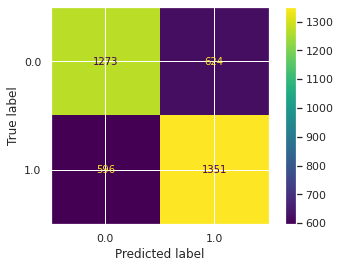

In [21]:
plot_confusion_matrix(clf, X_test, y_test, labels=clf.classes_)

In [22]:
clr = classification_report(y_test, y_pred, labels=clf.classes_)
print(clr)

              precision    recall  f1-score   support

         0.0       0.68      0.67      0.68      1897
         1.0       0.68      0.69      0.69      1947

    accuracy                           0.68      3844
   macro avg       0.68      0.68      0.68      3844
weighted avg       0.68      0.68      0.68      3844



## We are doing very bad. In general, this data is very challenging and complex as mentioned on the Kaggle. We will try something else for evaluation and interpretation.

# PyCaret to identify the best model.

In [23]:
!pip install pycaret

     |████████████████████████████████| 61kB 8.2MB/s 
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [24]:
import pycaret.classification as pyc

# Data Preparation for PyCaret

In [25]:
def data_preparation(df):
  df = df.copy()

  #drop unnecessary columns
  df = df.drop(["SubjectID", "VideoID", "predefinedlabel"], axis=1)

  #rename columns name 
  df.rename(columns={' age': 'Age', ' ethnicity': 'Ethnicity', ' gender': 'Gender', 'user-definedlabeln': 'Label'}, inplace=True)

  #binary encoding the Gender column
  df['Gender'] = df['Gender'].apply(lambda x: 1  if x == 'M' else 0)


  return df


In [26]:
X = data_preparation(data)

In [27]:
X

,Age,Ethnicity,Gender,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,Label
0,25,Han Chinese,1,56.0,43.0,278.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0.0
1,25,Han Chinese,1,40.0,35.0,-50.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0.0
2,25,Han Chinese,1,47.0,48.0,101.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,0.0
3,25,Han Chinese,1,47.0,57.0,-5.0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0,0.0
4,25,Han Chinese,1,44.0,53.0,-8.0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12806,24,Han Chinese,0,64.0,38.0,-39.0,127574.0,9951.0,709.0,21732.0,3872.0,39728.0,2598.0,960.0,0.0
12807,24,Han Chinese,0,61.0,35.0,-275.0,323061.0,797464.0,153171.0,145805.0,39829.0,571280.0,36574.0,10010.0,0.0
12808,24,Han Chinese,0,60.0,29.0,-426.0,680989.0,154296.0,40068.0,39122.0,10966.0,26975.0,20427.0,2024.0,0.0
12809,24,Han Chinese,0,60.0,29.0,-84.0,366269.0,27346.0,11444.0,9932.0,1939.0,3283.0,12323.0,1764.0,0.0


In [28]:
pyc.setup(
    data = X,
    target = 'Label',
    train_size = 0.7,
    normalize = True
)

,Description,Value
0,session_id,5555
1,Target,Label
2,Target Type,Binary
3,Label Encoded,"0.0: 0, 1.0: 1"
4,Original Data,"(12811, 15)"
5,Missing Values,False
6,Numeric Features,11
7,Categorical Features,3
8,Ordinal Features,False
9,High Cardinality Features,False


(5,
 -1,
 False,
 False,
 StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
 True,
 <MLUsecase.CLASSIFICATION: 1>,
 'lightgbm',
 {'USI',
  'X',
  'X_test',
  'X_train',
  '_all_metrics',
  '_all_models',
  '_all_models_internal',
  '_available_plots',
  '_gpu_n_jobs_param',
  '_internal_pipeline',
  '_ml_usecase',
  'create_model_container',
  'data_before_preprocess',
  'display_container',
  'exp_name_log',
  'experiment__',
  'fix_imbalance_method_param',
  'fix_imbalance_param',
  'fold_generator',
  'fold_groups_param',
  'fold_param',
  'fold_shuffle_param',
  'gpu_param',
  'html_param',
  'imputation_classifier',
  'imputation_regressor',
  'iterative_imputation_iters_param',
  'log_plots_param',
  'logging_param',
  'master_model_container',
  'n_jobs_param',
  'prep_pipe',
  'pycaret_globals',
  'seed',
  'stratify_param',
  'target_param',
  'transform_target_method_param',
  'transform_target_param',
  'y',
  'y_test',
  'y_train'},
 'lightgbm',
 10,
        A

In [29]:
pyc.compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.6973,0.7614,0.7118,0.7018,0.7067,0.3941,0.3943,1.013
rf,Random Forest Classifier,0.6897,0.7596,0.7114,0.6921,0.7014,0.3787,0.3791,1.652
lightgbm,Light Gradient Boosting Machine,0.6803,0.7473,0.7055,0.6817,0.6932,0.3596,0.3601,0.227
gbc,Gradient Boosting Classifier,0.6660,0.7238,0.6897,0.6689,0.6789,0.3311,0.3315,1.936
knn,K Neighbors Classifier,0.6306,0.6777,0.6296,0.6423,0.6358,0.2612,0.2614,0.241
ada,Ada Boost Classifier,0.6267,0.6713,0.6403,0.6347,0.6373,0.2529,0.2530,0.489
dt,Decision Tree Classifier,0.5946,0.5942,0.6096,0.6038,0.6065,0.1885,0.1887,0.099
lr,Logistic Regression,0.5898,0.6305,0.5852,0.6030,0.5938,0.1798,0.1800,0.274
ridge,Ridge Classifier,0.5879,0.0000,0.5822,0.6014,0.5914,0.1760,0.1762,0.020
lda,Linear Discriminant Analysis,0.5879,0.6296,0.5824,0.6013,0.5915,0.1760,0.1762,0.036


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=5555, verbose=0,
                     warm_start=False)

## In Pipeline, we used RandomForestClassifier(), as it works well on the most of the classification problems but interpretation is little difficult than Logistic or Decision Tree. It is "Accuracy-Interpretation" trade-off.

Using PyCaret compare models function, we can quickly see which model is doing good. ExtraTree for example in this case.

In [30]:
best_model = pyc.create_model('et')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7057,0.7745,0.7304,0.7059,0.7179,0.4104,0.4107
1,0.6845,0.7569,0.7152,0.6840,0.6993,0.3678,0.3682
2,0.7023,0.7590,0.7022,0.7130,0.7076,0.4045,0.4046
3,0.7035,0.7727,0.7435,0.6980,0.7200,0.4055,0.4064
4,0.7113,0.7620,0.7326,0.7125,0.7224,0.4217,0.4219
5,0.7101,0.7659,0.7124,0.7187,0.7155,0.4201,0.4201
6,0.7035,0.7667,0.7168,0.7075,0.7121,0.4064,0.4064
7,0.6663,0.7289,0.6558,0.6810,0.6681,0.3328,0.3330
8,0.6842,0.7499,0.7059,0.6864,0.6960,0.3675,0.3676
9,0.7020,0.7778,0.7037,0.7115,0.7076,0.4038,0.4038


In [31]:
pyc.evaluate_model(best_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [32]:
pyc.save_model(best_model, "eeg_confusion_model")

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[], target='Label',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_strate...
                  ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                       class_weight=None, criterion='gini',
                                       max_depth=None, max_features='auto',
                                       max_leaf_nod

# Using Neural Net

We will do an ANN.

In [33]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

In [34]:
def data_inputs_tf(df):
  #drop unnecessary columns
  df = df.drop(["SubjectID", "VideoID", "predefinedlabel"], axis=1)

  #rename columns name 
  df.rename(columns={' age': 'Age', ' ethnicity': 'Ethnicity', ' gender': 'Gender', 'user-definedlabeln': 'Label'}, inplace=True)

  #binary encoding the Gender column
  df['Gender'] = df['Gender'].apply(lambda x: 1  if x == 'M' else 0)

  #one hot encode the "Ethnicity column"
  ethnicity_dummies = pd.get_dummies(df['Ethnicity'])
  df = pd.concat([df, ethnicity_dummies], axis=1)
  df = df.drop('Ethnicity', axis=1)


  #X and y
  X = df.drop("Label", axis=1)
  y = df['Label']

  # Scale the data as all the columns will be in same range (mean of 0 and variance of 1)
  scaler = StandardScaler()
  X = scaler.fit_transform(X)

  #split the data
  X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7, shuffle=True, random_state=1)
 

  return X_train, X_test, y_train, y_test

In [35]:
X_train, X_test, y_train, y_test = data_inputs_tf(data)

In [36]:
X_train

array([[ 1.17458835, -1.99377673,  1.23903195, ..., -0.33533899,
        -0.33375238,  0.50204819],
       [-0.63941983,  0.50156067, -0.1431351 , ..., -0.33533899,
        -0.33375238,  0.50204819],
       [-0.63941983,  0.50156067, -0.31590598, ...,  2.98205702,
        -0.33375238, -1.99184067],
       ...,
       [-0.63941983,  0.50156067,  0.97987563, ...,  2.98205702,
        -0.33375238, -1.99184067],
       [-0.63941983, -1.99377673, -0.74783318, ..., -0.33533899,
        -0.33375238,  0.50204819],
       [-0.18591779,  0.50156067, -0.92060406, ..., -0.33533899,
        -0.33375238,  0.50204819]])

In [37]:
y_train

4141     0.0
1812     1.0
6428     0.0
1916     1.0
7217     1.0
        ... 
10955    1.0
905      0.0
5192     0.0
12172    1.0
235      1.0
Name: Label, Length: 8967, dtype: float64

# Model architecture

In [39]:
inputs = tf.keras.Input(shape=(X_train.shape[1]))
x = tf.keras.layers.Dense(256, activation='relu')(inputs)
x = tf.keras.layers.Dense(256, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs, outputs)


model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc')
    ]
)

batch_size = 32
epochs = 50

history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau()
    ]
)

Epoch 1/50
225/225 [==============================] - 5s 7ms/step - loss: 0.6603 - accuracy: 0.6091 - auc: 0.6523 - val_loss: 0.6283 - val_accuracy: 0.6494 - val_auc: 0.7027
Epoch 2/50
225/225 [==============================] - 1s 4ms/step - loss: 0.6314 - accuracy: 0.6353 - auc: 0.6924 - val_loss: 0.6307 - val_accuracy: 0.6327 - val_auc: 0.6998
Epoch 3/50
225/225 [==============================] - 1s 4ms/step - loss: 0.6162 - accuracy: 0.6489 - auc: 0.7132 - val_loss: 0.6171 - val_accuracy: 0.6499 - val_auc: 0.7158
Epoch 4/50
225/225 [==============================] - 1s 4ms/step - loss: 0.6133 - accuracy: 0.6591 - auc: 0.7200 - val_loss: 0.6253 - val_accuracy: 0.6421 - val_auc: 0.7205
Epoch 5/50
225/225 [==============================] - 1s 4ms/step - loss: 0.6076 - accuracy: 0.6654 - auc: 0.7283 - val_loss: 0.6095 - val_accuracy: 0.6656 - val_auc: 0.7306
Epoch 6/50
225/225 [==============================] - 1s 4ms/step - loss: 0.5994 - accuracy: 0.6685 - auc: 0.7360 - val_loss: 0.61

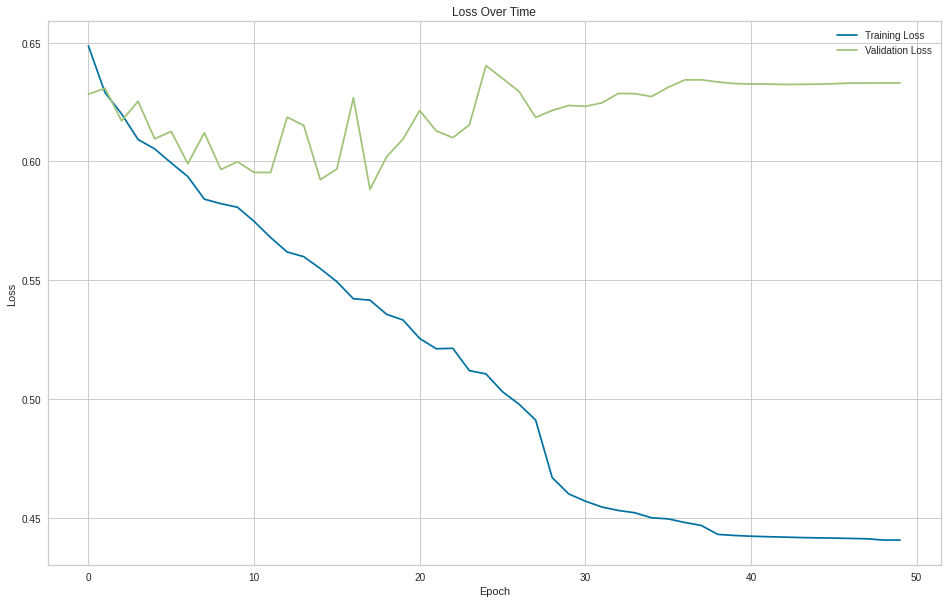

In [40]:
plt.figure(figsize=(16, 10))

plt.plot(range(epochs), history.history['loss'], label="Training Loss")
plt.plot(range(epochs), history.history['val_loss'], label="Validation Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Over Time")
plt.legend()

plt.show()

In [41]:
model.evaluate(X_test, y_test)

121/121 [==============================] - 0s 3ms/step - loss: 0.6661 - accuracy: 0.6707 - auc: 0.7279


[0.666136622428894, 0.6706555485725403, 0.7278814315795898]

In [42]:
y_true = np.array(y_test)

y_pred = np.squeeze(model.predict(X_test))
y_pred = np.array(y_pred >= 0.5, dtype=np.int)

In [44]:
from sklearn.metrics import confusion_matrix

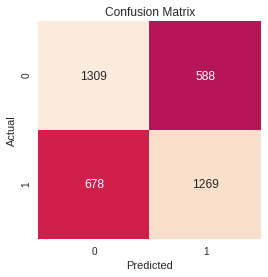

In [45]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(4, 4))

sns.heatmap(cm, annot=True, fmt='g', vmin=0, cbar=False)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

plt.show()

In [46]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.66      0.69      0.67      1897
         1.0       0.68      0.65      0.67      1947

    accuracy                           0.67      3844
   macro avg       0.67      0.67      0.67      3844
weighted avg       0.67      0.67      0.67      3844

